For this tutorial the following packages are required in addition to the `simframe` requirements:

* `astropy`
* `matplotlib`

In this tutorial you'll learn about the usage of groups and the setup of more complex integration instructions.

# Advanced Integration

Let's have a look at orbital integration.\
Consider a planet (we'll call it "Earth") orbiting a star (let's say the "Sun"). How does its orbit look like?

The equations of motion are determined by a set of two differential equations for the object's position $\vec{r}$ and velocity $\vec{v}$.

$\frac{\mathrm{d}}{\mathrm{d}t} \vec{r} = \vec{v}$

$m\frac{\mathrm{d}}{\mathrm{d}t} \vec{v} = \vec{F}_\mathrm{G}$

The gravitational force $F_\mathrm{G}$ of a body of mass $M$ and position $\vec{R}$ acting on a body of mass $m$ at position $\vec{r}$ is given by

$\vec{F}_\mathrm{G} = -GmM\frac{\vec{r}-\vec{R}}{\left| \vec{r}-\vec{R} \right|^3}$

## Setting up the problem

First we need to add fields for postion, velocity, and mass for Earth and Sun.\
To have more structure we group the fields by Earth and Sun.

In [1]:
from simframe import Frame

In [2]:
sim = Frame(description="Sun-Earth system")

In [3]:
sim.addgroup("Sun")
sim.addgroup("Earth")

In [4]:
sim

Frame (Sun-Earth system)
------------------------
    Earth        : Group
    Sun          : Group
  -----
    Integrator   : not specified
    Writer       : not specified

We will keep the problem general in three dimensions, but we will only use two of them for simplicity.\
Although spherical coordinates would be more suitable for the problem, we will use Carteesian coordinates here.

We'll use the `astropy.constants` and `astropy.units` modules for the constants and units we need here.

In [5]:
import astropy.constants as c
import astropy.units as u

In [6]:
AU   = (1.*u.au).si.value
day  = (1.*u.day).si.value
G    = c.G.si.value
year = (1.*u.year).si.value

M_earth = c.M_earth.si.value
M_sun   = c.M_sun.si.value

In [7]:
sim.Earth.addfield("M", M_earth, description="Mass [kg]")

The groups and the fields within can be easily accessed with

In [8]:
sim.Earth

Group
-----
    M            : Field (Mass [kg])
  -----

In [9]:
sim.Earth.M

5.972167867791379e+24

For this simulation the masses of Earth and Sun shall be constant. We can make them immutable to make sure that we do not accitentially change them.

In [10]:
sim.Earth.M.constant = True

In [11]:
sim.Earth

Group
-----
    M            : Field (Mass [kg]), constant
  -----

Now we need to add fields for position and velocity. We initialize them with zeros and think later about initial conditions.\
The important thing is that the have the right shape upon initialization.

In [12]:
import numpy as np

In [13]:
sim.Earth.addfield("r", np.zeros(3), description="Position [m]")
sim.Earth.addfield("v", np.zeros(3), description="Velocity [m/s]")

In [14]:
sim.Earth

Group
-----
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    v            : Field (Velocity [m/s])
  -----

Now we have to do the same for the Sun.\
We can set the mass to a constant value already when adding the field via a keyword argument.

In [15]:
sim.Sun.addfield("M", c.M_sun.si.value, description="Mass [kg]", constant=True)
sim.Sun.addfield("r", np.zeros(3), description="Position [m]")
sim.Sun.addfield("v", np.zeros(3), description="Velocity [m/s]")

In [16]:
sim.Sun

Group
-----
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    v            : Field (Velocity [m/s])
  -----

It's possible to have all kinds of mathematical operations with the fields just as for regular NumPy ararys.\
For example: What is the ratio of Earth's mass to the Sun's?

In [17]:
sim.Earth.M / sim.Sun.M

3.0034893488507934e-06

For our simulation we need an integration variable. In our case this is the time.

In [18]:
sim.addintegrationvariable("t", 0., description="Time [s]")

We'll set the step size to a constant value of one day.

In [19]:
dt = 1.*day

In [20]:
def f_dt(sim):
    return dt

In [21]:
sim.t.updater = f_dt

We want to integrate for two years and want to have a snapshot every ten days.

In [22]:
snapwidth = 10.*day
tmax = 2.*year

In [23]:
sim.t.snapshots = np.arange(snapwidth, tmax+1, snapwidth)

#### Note:
`simframe` automatically writes an output file with the initial conditions, if the value of the integration variable is below first snapshot (if a writer is set).\
We add 1 second to the final snapshot to make sure that it gets written.

In [24]:
sim

Frame (Sun-Earth system)
------------------------
    Earth        : Group
    Sun          : Group
  -----
    t            : Field (Time [s]), Integration variable
  -----
    Integrator   : not specified
    Writer       : not specified

As a writer we use the HDF5 writer.

In [25]:
from simframe import writers

In [26]:
sim.writer = writers.hdf5writer

In [27]:
sim.writer.datadir = "2_data"
sim.writer.overwrite = True

In [28]:
sim.writer

Writer (HDF5 file format using h5py)
------------------------------------
    Data directory : 2_data
    File names     : 2_data/data0000.hdf5
    Overwrite      : True
    options        : {'com': 'lzf', 'comopts': None}

## Adding differential equations

As a next step we'll add differential equations to the quantities. The differential equations for the positions are simple.

In [29]:
def dr_Earth(sim, r):
    return sim.Earth.v

def dr_Sun(sim, r):
    return sim.Sun.v

For the differential equations of the velocities we'll write a little helper function

In [30]:
# Gravitational acceleration
def ag(M, r, R):
    direction = r-R
    distance = np.linalg.norm(direction)
    return -G * M * direction / distance**3

In [31]:
def dv_Earth(sim, v):
    return ag(sim.Sun.M, sim.Earth.r, sim.Sun.r)

def dv_Sun(sim, v):
    return ag(sim.Earth.M, sim.Sun.r, sim.Earth.r)

Now we need to add the differential equations to their fields.

In [32]:
sim.Earth.v.differentiator = dv_Earth
sim.Earth.r.differentiator = dr_Earth
sim.Sun.v.differentiator   = dv_Sun
sim.Sun.r.differentiator   = dr_Sun

## Setting up the integrator

Next we need to set up the integrator. We integrate all quantities with the explicit Euler 1st order scheme as in the previous tutorial.

In [33]:
from simframe import Integrator

In [34]:
integrator_euler = Integrator(sim.t, description="Simple Euler integrator")

The instruction set for the integrator is quite simple.

In [35]:
from simframe import schemes
from simframe.integration import Instruction

In [36]:
instructions_euler = [Instruction(schemes.expl_1_euler, sim.Earth.r),
                      Instruction(schemes.expl_1_euler, sim.Earth.v),
                      Instruction(schemes.expl_1_euler, sim.Sun.r  ),
                      Instruction(schemes.expl_1_euler, sim.Sun.v  ),
                     ]

In [37]:
integrator_euler.instructions = instructions_euler

In [38]:
sim.integrator = integrator_euler

## Initial conditions

We're not quite ready to go. We still have to define the initial positions and velocities of Earth and Sun.

We could simply set the Sun's position and velocity to zero and only set Earth's parameters. But then the center-of-mass would have a non-zero velocity in our reference frame and would slowly drift away from it's initial position.

So what we do first: we set the Sun's positon to zero (i.e., don't do anything) and the Earth's position to a distance of 1 AU in positive x-direction. Then we'll offset their positions to center the system on the center of mass.

In [39]:
r_Earth_ini = np.array([AU, 0., 0.])
r_Sun_ini = np.zeros(3)
# Center of mass
COM_ini = (M_earth*r_Earth_ini + M_sun*r_Sun_ini) / (M_earth+M_sun)
# Offset both positions
r_Earth_ini -= COM_ini
r_Sun_ini -= COM_ini

We save them in a separate variable instead of assigning them directly for later use.

The inital orbital velocities of the Earth shall be in positive y-direction, the velocity of the Sun in negative y-direction.\
For calculating the value use the reduced mass $mu$ of the system.

In [40]:
mu = M_earth*M_sun / (M_earth+M_sun)

In [41]:
v_Earth_ini = np.array([0., np.sqrt(G*M_sun/M_earth*mu/AU), 0.])
v_Sun_ini   = np.array([0., -np.sqrt(G*M_earth/M_sun*mu/AU), 0.])

Now we assign them to their fields.

In [42]:
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini

## Starting the simulation

In [43]:
sim.run()

Creating data directory '2_data'.
Writing file '2_data/data0000.hdf5'
Writing file '2_data/data0001.hdf5'
Writing file '2_data/data0002.hdf5'
Writing file '2_data/data0003.hdf5'
Writing file '2_data/data0004.hdf5'
Writing file '2_data/data0005.hdf5'
Writing file '2_data/data0006.hdf5'
Writing file '2_data/data0007.hdf5'
Writing file '2_data/data0008.hdf5'
Writing file '2_data/data0009.hdf5'
Writing file '2_data/data0010.hdf5'
Writing file '2_data/data0011.hdf5'
Writing file '2_data/data0012.hdf5'
Writing file '2_data/data0013.hdf5'
Writing file '2_data/data0014.hdf5'
Writing file '2_data/data0015.hdf5'
Writing file '2_data/data0016.hdf5'
Writing file '2_data/data0017.hdf5'
Writing file '2_data/data0018.hdf5'
Writing file '2_data/data0019.hdf5'
Writing file '2_data/data0020.hdf5'
Writing file '2_data/data0021.hdf5'
Writing file '2_data/data0022.hdf5'
Writing file '2_data/data0023.hdf5'
Writing file '2_data/data0024.hdf5'
Writing file '2_data/data0025.hdf5'
Writing file '2_data/data0026.

## Reading and plotting data

In [44]:
data_euler = sim.writer.read.all()

In [45]:
import matplotlib.pyplot as plt
width = 2.
dpi = 300

def plot_orbits(data):
    fig, ax = plt.subplots(figsize=(width, width), dpi=dpi)
    ax.set_aspect(1)
    ax.axis("off")
    fig.set_facecolor("#000000")
    imax = data.t.shape[0]
    for i in range(imax):
        alpha = np.maximum(i/imax-0.2, 0.2)
        ax.plot(data.Sun.r[i, 0], data.Sun.r[i, 1], "o", c="#FFFF00", markersize=2, alpha=alpha)
        ax.plot(data.Earth.r[i, 0], data.Earth.r[i, 1], "o", c="#0000FF", markersize=0.5, alpha=alpha)
    ax.plot(data.Sun.r[-1, 0], data.Sun.r[-1, 1], "o", c="#FFFF00", markersize=8)
    ax.plot(data.Earth.r[-1, 0], data.Earth.r[-1, 1], "o", c="#0000FF", markersize=2)
    ax.set_xlim(-1.5*AU, 1.5*AU)
    ax.set_ylim(-1.5*AU, 1.5*AU)
    fig.tight_layout()

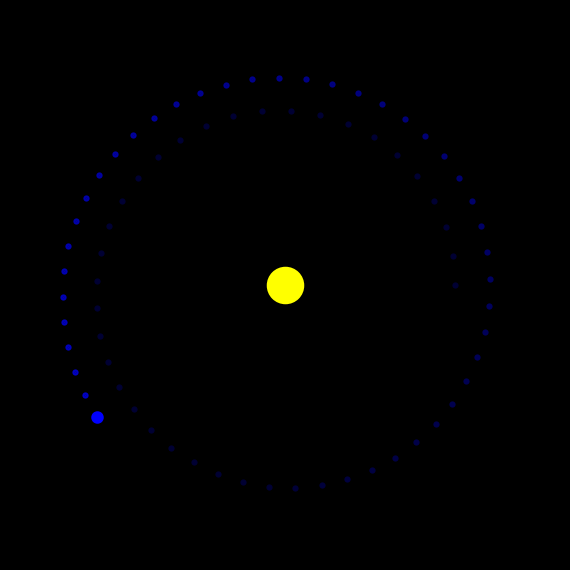

In [46]:
plot_orbits(data_euler)

## What went wrong?

As you can see, the Earth is not on a circular orbit. Its orbital distance is increasing and because of that the Earth could not achieve two full cycles.

The problem is the simple integration scheme used here.\
Every integration scheme has numerical error. Some have larger ones than others. Euler's 1st order method is simply not accurate enough for our problem.

But there is a way out: [Symplectic integration](https://en.wikipedia.org/wiki/Symplectic_integrator)\
Symplectic integrators conserve the energy of the system.

One of these methods is the Leapfrog method.\
Leapfrogging means the velocity and the position are not updated synchronous, but in between each other. They are leapfroggin each other.

In our case we first update the velocities by using half of the step size.\
Usually the fields are only updated at the end of the instruction set, to make sure that the following instruction still has the old values available. But in our case the next instructions need the new velocities and not the old ones. There is an in-built instruction for updating fields that can be used here.

Then we'll integrate and update the positions for a full time step using the updated velocities.

And lastly, we'll integrate the velocities again for another half of the timestep with the new updated positions.\
We do not need the `update` instructions here, because they are automatically updated at the end of the instruction set.

The instruction set now looks like this.

In [47]:
instructions_leapfrog = [Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                         Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
                         Instruction(schemes.update,       sim.Sun.v             ),
                         Instruction(schemes.update,       sim.Earth.v           ),
                         Instruction(schemes.expl_1_euler, sim.Sun.r,   fstep=1.0),
                         Instruction(schemes.expl_1_euler, sim.Earth.r, fstep=1.0),
                         Instruction(schemes.update,       sim.Sun.r             ),
                         Instruction(schemes.update,       sim.Earth.r           ),
                         Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                         Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
                        ]

We can assign this new instruction set to our frame, and change the output directory, re-set the initial conditions, that we've saved before and re-run the simulation.

In [48]:
sim.integrator.instructions = instructions_leapfrog
sim.writer.datadir = "2_data_leapfrog"
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini
sim.t       = 0.

In [49]:
sim.run()

Creating data directory '2_data_leapfrog'.
Writing file '2_data_leapfrog/data0000.hdf5'
Writing file '2_data_leapfrog/data0001.hdf5'
Writing file '2_data_leapfrog/data0002.hdf5'
Writing file '2_data_leapfrog/data0003.hdf5'
Writing file '2_data_leapfrog/data0004.hdf5'
Writing file '2_data_leapfrog/data0005.hdf5'
Writing file '2_data_leapfrog/data0006.hdf5'
Writing file '2_data_leapfrog/data0007.hdf5'
Writing file '2_data_leapfrog/data0008.hdf5'
Writing file '2_data_leapfrog/data0009.hdf5'
Writing file '2_data_leapfrog/data0010.hdf5'
Writing file '2_data_leapfrog/data0011.hdf5'
Writing file '2_data_leapfrog/data0012.hdf5'
Writing file '2_data_leapfrog/data0013.hdf5'
Writing file '2_data_leapfrog/data0014.hdf5'
Writing file '2_data_leapfrog/data0015.hdf5'
Writing file '2_data_leapfrog/data0016.hdf5'
Writing file '2_data_leapfrog/data0017.hdf5'
Writing file '2_data_leapfrog/data0018.hdf5'
Writing file '2_data_leapfrog/data0019.hdf5'
Writing file '2_data_leapfrog/data0020.hdf5'
Writing file

In [50]:
data_leapfrog = sim.writer.read.all()

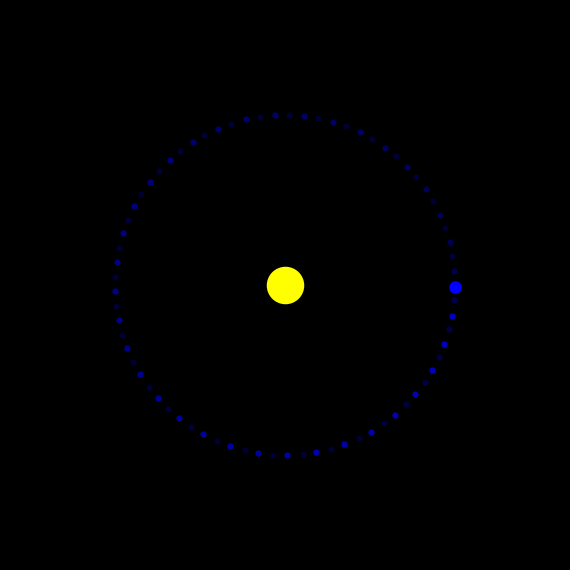

In [51]:
plot_orbits(data_leapfrog)